In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [3]:
train = pd.read_csv('Train.csv', index_col='id')
test = pd.read_csv('Test.csv')

In [4]:
train.columns, test.columns

(Index(['date', 'street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon',
        'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
        'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13', 'price'],
       dtype='object'),
 Index(['id', 'date', 'street_id', 'build_tech', 'floor', 'area', 'rooms',
        'balcon', 'metro_dist', 'g_lift', 'n_photos', 'kw1', 'kw2', 'kw3',
        'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12',
        'kw13'],
       dtype='object'))

In [5]:
train.head(2)

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-01-01,531,NaN,12,35,1,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,3721000
1,2011-01-01,385,2.0,15,46,1,2,15.0,1.0,1,...,0,0,0,0,0,0,0,0,0,7431000


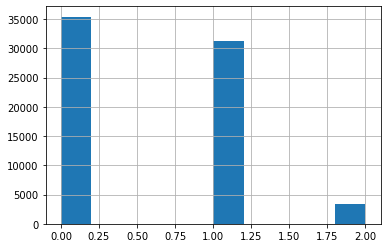

In [6]:
train['build_tech'].dropna().hist()

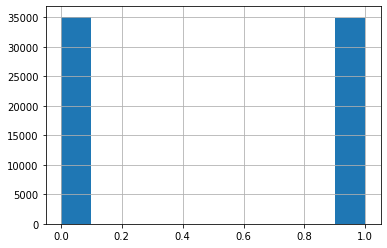

In [7]:
train['g_lift'].dropna().hist()

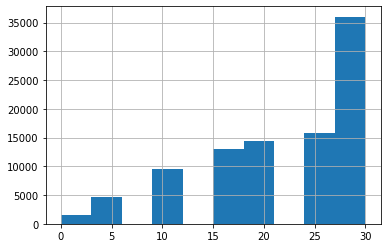

In [8]:
train['metro_dist'].dropna().hist()

## Что делать с пропусками?
## ---------------------------------------
    build_tech = 0
    g_lift = 0
    metro_dist = возьмём среднее / медиану
## ---------------------------------------

In [9]:
train['metro_dist'].median(), train['metro_dist'].mean()

(25.0, 21.85854259192995)

In [10]:
train['build_tech'] = train['build_tech'].fillna(0)
train['g_lift'] = train['g_lift'].fillna(0)
train['metro_dist'] = train['metro_dist'].fillna(train['metro_dist'].mean())

test['build_tech'] = test['build_tech'].fillna(0)
test['g_lift'] = test['g_lift'].fillna(0)
test['metro_dist'] = test['metro_dist'].fillna(test['metro_dist'].mean())

### Let's go

In [11]:
X, y = train.iloc[:, 1:-1], train['price']

# 2 различные модели:
1. xgboost - спускаемся сразу ниже до заголовка "XGBOOST"
2. стекаем модели: обучаем несколько бустингов на случайных батчах из train, переходим к новым признакам для валидации и теста, дальше обучаем линейную регрессию на новых признаках

# stack(xgb1, ..., xgbn)

In [22]:
def stack(X, y, test, p_meta=0.4):
    X, X_meta, y, y_meta = train_test_split(X, y, test_size=p_meta, random_state=17)
    
    X_fin = pd.DataFrame()
    test_fin = pd.DataFrame()
    
    est = [200, 200, 200, 300, 300, 500, 500, 700]
    rnd = [300, 500, 700, 400, 900, 500, 1000, 1200]
    
    for i in range(len(est)):
        X_full, unx, y_full, uny = train_test_split(X, y, test_size=0.25)
        X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=1)
        
        data = xgb.DMatrix(data=X_full,label=y_full)
        dtrain= xgb.DMatrix(data=X_train,label=y_train)
        dval= xgb.DMatrix(data=X_val,label=y_val)
        
        param = {'objective' : 'reg:linear', 'learning_rate' : 0.1, 'colsample_bytree': 0.8, 
             'n_estimators':est[i], 'max_depth': 10, 'reg_alpha': 1, 'eval_metric': 'mae'}
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        bst = xgb.train(param, data, rnd[i], evallist)
        
        dmeta = xgb.DMatrix(X_meta)
        X_fin['rnd{}_est{}'.format(rnd[i], est[i])] = bst.predict(dmeta)
        
        dtest = xgb.DMatrix(test)
        test_fin['rnd{}_est{}'.format(rnd[i], est[i])] = bst.predict(dtest)
    
    return X_fin, y_meta, test_fin

In [23]:
z1,z2,z3 = stack(X,y, test.iloc[:,2:])

[15:22:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:4.51238e+06	train-mae:4.46321e+06
[1]	eval-mae:4.07545e+06	train-mae:4.02817e+06
[2]	eval-mae:3.69558e+06	train-mae:3.64952e+06
[3]	eval-mae:3.35925e+06	train-mae:3.31265e+06
[4]	eval-mae:3.0622e+06	train-mae:3.01709e+06
[5]	eval-mae:2.80201e+06	train-mae:2.75904e+06
[6]	eval-mae:2.57856e+06	train-mae:2.53654e+06
[7]	eval-mae:2.38563e+06	train-mae:2.34604e+06
[8]	eval-mae:2.22166e+06	train-mae:2.18389e+06
[9]	eval-mae:2.08222e+06	train-mae:2.04618e+06
[10]	eval-mae:1.96507e+06	train-mae:1.93057e+06
[11]	eval-mae:1.86645e+06	train-mae:1.83485e+06
[12]	eval-mae:1.78378e+06	train-mae:1.75531e+06
[13]	eval-mae:1.71447e+06	train-mae:1.68805e+06
[14]	eval-mae:1.6572e+06	train-mae:1.63307e+06
[15]	eval-mae:1.60765e+06	train-mae:1.58632e+06
[16]	eval-mae:1.56673e+06	train-mae:1.54775e+06
[17]	eval-mae:1.53448e+06	train-

[192]	eval-mae:594073	train-mae:596533
[193]	eval-mae:591736	train-mae:594022
[194]	eval-mae:588852	train-mae:590975
[195]	eval-mae:587445	train-mae:589602
[196]	eval-mae:586112	train-mae:588624
[197]	eval-mae:583967	train-mae:586483
[198]	eval-mae:582884	train-mae:585370
[199]	eval-mae:582330	train-mae:584859
[200]	eval-mae:578302	train-mae:581161
[201]	eval-mae:575948	train-mae:578417
[202]	eval-mae:575476	train-mae:577952
[203]	eval-mae:572117	train-mae:574531
[204]	eval-mae:570554	train-mae:572504
[205]	eval-mae:568651	train-mae:570735
[206]	eval-mae:566491	train-mae:568443
[207]	eval-mae:564295	train-mae:566288
[208]	eval-mae:563261	train-mae:565128
[209]	eval-mae:561774	train-mae:563662
[210]	eval-mae:561067	train-mae:562921
[211]	eval-mae:560333	train-mae:562202
[212]	eval-mae:557236	train-mae:559639
[213]	eval-mae:556247	train-mae:558687
[214]	eval-mae:554227	train-mae:556476
[215]	eval-mae:552382	train-mae:554859
[216]	eval-mae:551461	train-mae:554062
[217]	eval-mae:548873	tra

[83]	eval-mae:923694	train-mae:925441
[84]	eval-mae:913362	train-mae:915427
[85]	eval-mae:905892	train-mae:907225
[86]	eval-mae:891497	train-mae:893533
[87]	eval-mae:879771	train-mae:882204
[88]	eval-mae:874039	train-mae:875896
[89]	eval-mae:871271	train-mae:873596
[90]	eval-mae:869580	train-mae:872168
[91]	eval-mae:864829	train-mae:867202
[92]	eval-mae:861454	train-mae:863754
[93]	eval-mae:853760	train-mae:856416
[94]	eval-mae:848106	train-mae:850424
[95]	eval-mae:840455	train-mae:843098
[96]	eval-mae:839279	train-mae:842011
[97]	eval-mae:834444	train-mae:836468
[98]	eval-mae:832162	train-mae:834586
[99]	eval-mae:822884	train-mae:826024
[100]	eval-mae:821186	train-mae:824356
[101]	eval-mae:819537	train-mae:822968
[102]	eval-mae:815492	train-mae:818772
[103]	eval-mae:807372	train-mae:810996
[104]	eval-mae:805632	train-mae:809378
[105]	eval-mae:797378	train-mae:801142
[106]	eval-mae:794139	train-mae:797549
[107]	eval-mae:790028	train-mae:793505
[108]	eval-mae:781718	train-mae:785692
[10

[294]	eval-mae:443262	train-mae:449664
[295]	eval-mae:442209	train-mae:448612
[296]	eval-mae:441729	train-mae:448083
[297]	eval-mae:441353	train-mae:447790
[298]	eval-mae:440544	train-mae:446832
[299]	eval-mae:439582	train-mae:445758
[300]	eval-mae:439220	train-mae:445449
[301]	eval-mae:438605	train-mae:444789
[302]	eval-mae:437630	train-mae:443780
[303]	eval-mae:436719	train-mae:442906
[304]	eval-mae:435746	train-mae:442022
[305]	eval-mae:434867	train-mae:441148
[306]	eval-mae:433493	train-mae:439916
[307]	eval-mae:432607	train-mae:439083
[308]	eval-mae:431818	train-mae:438210
[309]	eval-mae:430822	train-mae:437250
[310]	eval-mae:430339	train-mae:436669
[311]	eval-mae:429280	train-mae:435384
[312]	eval-mae:428160	train-mae:434299
[313]	eval-mae:427197	train-mae:433370
[314]	eval-mae:426390	train-mae:432593
[315]	eval-mae:425468	train-mae:431703
[316]	eval-mae:424390	train-mae:430800
[317]	eval-mae:423356	train-mae:429853
[318]	eval-mae:422282	train-mae:428767
[319]	eval-mae:421224	tra

[15:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:4.44245e+06	train-mae:4.52645e+06
[1]	eval-mae:4.00819e+06	train-mae:4.08678e+06
[2]	eval-mae:3.62782e+06	train-mae:3.70446e+06
[3]	eval-mae:3.29095e+06	train-mae:3.36473e+06
[4]	eval-mae:2.99451e+06	train-mae:3.06637e+06
[5]	eval-mae:2.73493e+06	train-mae:2.80518e+06
[6]	eval-mae:2.5111e+06	train-mae:2.58099e+06
[7]	eval-mae:2.32158e+06	train-mae:2.38834e+06
[8]	eval-mae:2.15949e+06	train-mae:2.22352e+06
[9]	eval-mae:2.02262e+06	train-mae:2.08401e+06
[10]	eval-mae:1.90728e+06	train-mae:1.96696e+06
[11]	eval-mae:1.81136e+06	train-mae:1.86844e+06
[12]	eval-mae:1.73149e+06	train-mae:1.7869e+06
[13]	eval-mae:1.66395e+06	train-mae:1.71731e+06
[14]	eval-mae:1.60908e+06	train-mae:1.66101e+06
[15]	eval-mae:1.56178e+06	train-mae:1.61264e+06
[16]	eval-mae:1.52199e+06	train-mae:1.57153e+06
[17]	eval-mae:1.49041e+06	train-

[193]	eval-mae:572066	train-mae:588483
[194]	eval-mae:569206	train-mae:585134
[195]	eval-mae:567817	train-mae:583610
[196]	eval-mae:567050	train-mae:582955
[197]	eval-mae:566565	train-mae:582472
[198]	eval-mae:565879	train-mae:581719
[199]	eval-mae:563941	train-mae:579899
[200]	eval-mae:560715	train-mae:576550
[201]	eval-mae:559332	train-mae:575114
[202]	eval-mae:558875	train-mae:574605
[203]	eval-mae:556682	train-mae:572536
[204]	eval-mae:553857	train-mae:569857
[205]	eval-mae:552545	train-mae:568511
[206]	eval-mae:550945	train-mae:566975
[207]	eval-mae:548778	train-mae:564760
[208]	eval-mae:547796	train-mae:563795
[209]	eval-mae:545520	train-mae:561581
[210]	eval-mae:544738	train-mae:560698
[211]	eval-mae:544304	train-mae:560155
[212]	eval-mae:543854	train-mae:559680
[213]	eval-mae:543063	train-mae:558904
[214]	eval-mae:540953	train-mae:556890
[215]	eval-mae:538512	train-mae:554562
[216]	eval-mae:537867	train-mae:553902
[217]	eval-mae:536078	train-mae:551686
[218]	eval-mae:534003	tra

[404]	eval-mae:366016	train-mae:373760
[405]	eval-mae:365510	train-mae:373172
[406]	eval-mae:364674	train-mae:372226
[407]	eval-mae:364385	train-mae:371884
[408]	eval-mae:364221	train-mae:371722
[409]	eval-mae:364003	train-mae:371508
[410]	eval-mae:363515	train-mae:371028
[411]	eval-mae:363064	train-mae:370512
[412]	eval-mae:362119	train-mae:369667
[413]	eval-mae:361584	train-mae:369128
[414]	eval-mae:361145	train-mae:368629
[415]	eval-mae:360320	train-mae:367895
[416]	eval-mae:359955	train-mae:367523
[417]	eval-mae:359774	train-mae:367318
[418]	eval-mae:359244	train-mae:366797
[419]	eval-mae:358954	train-mae:366422
[420]	eval-mae:358499	train-mae:365833
[421]	eval-mae:357852	train-mae:365282
[422]	eval-mae:357648	train-mae:365025
[423]	eval-mae:357062	train-mae:364398
[424]	eval-mae:356579	train-mae:363958
[425]	eval-mae:355666	train-mae:363136
[426]	eval-mae:355505	train-mae:362931
[427]	eval-mae:355279	train-mae:362755
[428]	eval-mae:354553	train-mae:362014
[429]	eval-mae:354360	tra

[615]	eval-mae:282416	train-mae:288885
[616]	eval-mae:281759	train-mae:288224
[617]	eval-mae:281395	train-mae:287854
[618]	eval-mae:280829	train-mae:287316
[619]	eval-mae:280530	train-mae:286989
[620]	eval-mae:280116	train-mae:286583
[621]	eval-mae:279763	train-mae:286181
[622]	eval-mae:279474	train-mae:285882
[623]	eval-mae:278953	train-mae:285314
[624]	eval-mae:278254	train-mae:284570
[625]	eval-mae:278021	train-mae:284361
[626]	eval-mae:277574	train-mae:283836
[627]	eval-mae:277102	train-mae:283357
[628]	eval-mae:276727	train-mae:282947
[629]	eval-mae:276580	train-mae:282799
[630]	eval-mae:276504	train-mae:282715
[631]	eval-mae:276110	train-mae:282316
[632]	eval-mae:275770	train-mae:282000
[633]	eval-mae:275531	train-mae:281753
[634]	eval-mae:275094	train-mae:281321
[635]	eval-mae:274839	train-mae:281076
[636]	eval-mae:274390	train-mae:280647
[637]	eval-mae:274153	train-mae:280408
[638]	eval-mae:273932	train-mae:280205
[639]	eval-mae:273510	train-mae:279736
[640]	eval-mae:272820	tra

[107]	eval-mae:808696	train-mae:814441
[108]	eval-mae:803910	train-mae:808897
[109]	eval-mae:802542	train-mae:807524
[110]	eval-mae:801014	train-mae:805836
[111]	eval-mae:798222	train-mae:803229
[112]	eval-mae:791116	train-mae:795874
[113]	eval-mae:786467	train-mae:791529
[114]	eval-mae:781768	train-mae:786823
[115]	eval-mae:780319	train-mae:785226
[116]	eval-mae:776345	train-mae:780976
[117]	eval-mae:775188	train-mae:779745
[118]	eval-mae:773612	train-mae:778168
[119]	eval-mae:767963	train-mae:772394
[120]	eval-mae:766735	train-mae:770870
[121]	eval-mae:760205	train-mae:764156
[122]	eval-mae:758543	train-mae:762591
[123]	eval-mae:754436	train-mae:758543
[124]	eval-mae:753596	train-mae:757758
[125]	eval-mae:751496	train-mae:755528
[126]	eval-mae:745842	train-mae:749701
[127]	eval-mae:741859	train-mae:745981
[128]	eval-mae:740932	train-mae:745107
[129]	eval-mae:734631	train-mae:738637
[130]	eval-mae:730000	train-mae:733764
[131]	eval-mae:727926	train-mae:731652
[132]	eval-mae:723179	tra

[318]	eval-mae:435543	train-mae:429442
[319]	eval-mae:435246	train-mae:429142
[320]	eval-mae:434504	train-mae:428375
[321]	eval-mae:432969	train-mae:426841
[322]	eval-mae:432068	train-mae:426104
[323]	eval-mae:431348	train-mae:425368
[324]	eval-mae:430530	train-mae:424449
[325]	eval-mae:429306	train-mae:423223
[326]	eval-mae:428993	train-mae:422933
[327]	eval-mae:427450	train-mae:421489
[328]	eval-mae:426663	train-mae:420614
[329]	eval-mae:425327	train-mae:419366
[330]	eval-mae:424814	train-mae:418900
[331]	eval-mae:423731	train-mae:417933
[332]	eval-mae:422990	train-mae:417193
[333]	eval-mae:422168	train-mae:416283
[334]	eval-mae:420992	train-mae:415160
[335]	eval-mae:419860	train-mae:414022
[336]	eval-mae:419127	train-mae:413176
[337]	eval-mae:417977	train-mae:412125
[338]	eval-mae:417594	train-mae:411735
[339]	eval-mae:417312	train-mae:411364
[340]	eval-mae:416468	train-mae:410560
[341]	eval-mae:415612	train-mae:409681
[342]	eval-mae:415355	train-mae:409412
[343]	eval-mae:414466	tra

[109]	eval-mae:793993	train-mae:797035
[110]	eval-mae:792125	train-mae:795196
[111]	eval-mae:787683	train-mae:790928
[112]	eval-mae:781532	train-mae:784817
[113]	eval-mae:779058	train-mae:782392
[114]	eval-mae:772699	train-mae:776147
[115]	eval-mae:771521	train-mae:774879
[116]	eval-mae:765991	train-mae:769542
[117]	eval-mae:761257	train-mae:765065
[118]	eval-mae:759629	train-mae:763462
[119]	eval-mae:757664	train-mae:761332
[120]	eval-mae:755876	train-mae:759564
[121]	eval-mae:753467	train-mae:757112
[122]	eval-mae:751761	train-mae:755338
[123]	eval-mae:748035	train-mae:751600
[124]	eval-mae:746878	train-mae:750553
[125]	eval-mae:742322	train-mae:746230
[126]	eval-mae:737476	train-mae:741537
[127]	eval-mae:734293	train-mae:738220
[128]	eval-mae:729861	train-mae:733868
[129]	eval-mae:723492	train-mae:727127
[130]	eval-mae:718460	train-mae:722276
[131]	eval-mae:716389	train-mae:719985
[132]	eval-mae:715074	train-mae:718675
[133]	eval-mae:713453	train-mae:716950
[134]	eval-mae:712196	tra

[320]	eval-mae:429988	train-mae:432186
[321]	eval-mae:429225	train-mae:431460
[322]	eval-mae:428273	train-mae:430402
[323]	eval-mae:427661	train-mae:429805
[324]	eval-mae:426284	train-mae:428360
[325]	eval-mae:425038	train-mae:427203
[326]	eval-mae:424449	train-mae:426638
[327]	eval-mae:423517	train-mae:425771
[328]	eval-mae:423255	train-mae:425463
[329]	eval-mae:422214	train-mae:424242
[330]	eval-mae:421227	train-mae:423367
[331]	eval-mae:420664	train-mae:422704
[332]	eval-mae:419702	train-mae:421743
[333]	eval-mae:419192	train-mae:421262
[334]	eval-mae:418354	train-mae:420356
[335]	eval-mae:417867	train-mae:419845
[336]	eval-mae:417012	train-mae:418858
[337]	eval-mae:416562	train-mae:418453
[338]	eval-mae:416061	train-mae:418039
[339]	eval-mae:415689	train-mae:417642
[340]	eval-mae:414791	train-mae:416875
[341]	eval-mae:414362	train-mae:416390
[342]	eval-mae:414077	train-mae:416075
[343]	eval-mae:413593	train-mae:415460
[344]	eval-mae:412607	train-mae:414471
[345]	eval-mae:411870	tra

[531]	eval-mae:311506	train-mae:313106
[532]	eval-mae:311080	train-mae:312688
[533]	eval-mae:310824	train-mae:312408
[534]	eval-mae:310381	train-mae:311928
[535]	eval-mae:310052	train-mae:311648
[536]	eval-mae:309657	train-mae:311174
[537]	eval-mae:309102	train-mae:310568
[538]	eval-mae:308892	train-mae:310344
[539]	eval-mae:308530	train-mae:309975
[540]	eval-mae:308158	train-mae:309662
[541]	eval-mae:307367	train-mae:308904
[542]	eval-mae:307066	train-mae:308641
[543]	eval-mae:306599	train-mae:308125
[544]	eval-mae:306401	train-mae:307951
[545]	eval-mae:306269	train-mae:307818
[546]	eval-mae:305889	train-mae:307462
[547]	eval-mae:305308	train-mae:306889
[548]	eval-mae:304792	train-mae:306368
[549]	eval-mae:304645	train-mae:306187
[550]	eval-mae:304084	train-mae:305687
[551]	eval-mae:303799	train-mae:305410
[552]	eval-mae:303194	train-mae:304866
[553]	eval-mae:302621	train-mae:304221
[554]	eval-mae:302268	train-mae:303878
[555]	eval-mae:302113	train-mae:303720
[556]	eval-mae:301974	tra

[742]	eval-mae:239832	train-mae:241879
[743]	eval-mae:239595	train-mae:241633
[744]	eval-mae:239332	train-mae:241382
[745]	eval-mae:239043	train-mae:241099
[746]	eval-mae:238953	train-mae:241003
[747]	eval-mae:238880	train-mae:240917
[748]	eval-mae:238595	train-mae:240636
[749]	eval-mae:238492	train-mae:240540
[750]	eval-mae:238384	train-mae:240426
[751]	eval-mae:238105	train-mae:240076
[752]	eval-mae:237925	train-mae:239897
[753]	eval-mae:237774	train-mae:239701
[754]	eval-mae:237520	train-mae:239471
[755]	eval-mae:237256	train-mae:239182
[756]	eval-mae:237001	train-mae:238882
[757]	eval-mae:236768	train-mae:238606
[758]	eval-mae:236620	train-mae:238423
[759]	eval-mae:236474	train-mae:238261
[760]	eval-mae:236290	train-mae:238113
[761]	eval-mae:236032	train-mae:237926
[762]	eval-mae:235897	train-mae:237787
[763]	eval-mae:235632	train-mae:237514
[764]	eval-mae:235426	train-mae:237315
[765]	eval-mae:235047	train-mae:237025
[766]	eval-mae:234744	train-mae:236724
[767]	eval-mae:234540	tra

[40]	eval-mae:1.24038e+06	train-mae:1.24009e+06
[41]	eval-mae:1.22794e+06	train-mae:1.22719e+06
[42]	eval-mae:1.21889e+06	train-mae:1.21892e+06
[43]	eval-mae:1.21548e+06	train-mae:1.21604e+06
[44]	eval-mae:1.203e+06	train-mae:1.20329e+06
[45]	eval-mae:1.19612e+06	train-mae:1.19669e+06
[46]	eval-mae:1.18316e+06	train-mae:1.1834e+06
[47]	eval-mae:1.16635e+06	train-mae:1.16696e+06
[48]	eval-mae:1.15973e+06	train-mae:1.16077e+06
[49]	eval-mae:1.15677e+06	train-mae:1.15775e+06
[50]	eval-mae:1.15039e+06	train-mae:1.15111e+06
[51]	eval-mae:1.14769e+06	train-mae:1.14837e+06
[52]	eval-mae:1.13649e+06	train-mae:1.13724e+06
[53]	eval-mae:1.13206e+06	train-mae:1.13276e+06
[54]	eval-mae:1.12019e+06	train-mae:1.12057e+06
[55]	eval-mae:1.11441e+06	train-mae:1.11542e+06
[56]	eval-mae:1.11026e+06	train-mae:1.11117e+06
[57]	eval-mae:1.10808e+06	train-mae:1.10914e+06
[58]	eval-mae:1.09812e+06	train-mae:1.09925e+06
[59]	eval-mae:1.09594e+06	train-mae:1.09714e+06
[60]	eval-mae:1.0821e+06	train-mae:1.08406e

[245]	eval-mae:505632	train-mae:506218
[246]	eval-mae:504302	train-mae:504944
[247]	eval-mae:503978	train-mae:504606
[248]	eval-mae:502129	train-mae:502908
[249]	eval-mae:501108	train-mae:501931
[250]	eval-mae:499433	train-mae:500059
[251]	eval-mae:498625	train-mae:499147
[252]	eval-mae:497047	train-mae:497579
[253]	eval-mae:495128	train-mae:495617
[254]	eval-mae:493370	train-mae:493912
[255]	eval-mae:492058	train-mae:492611
[256]	eval-mae:490759	train-mae:491384
[257]	eval-mae:489724	train-mae:490453
[258]	eval-mae:489045	train-mae:489692
[259]	eval-mae:487994	train-mae:488409
[260]	eval-mae:487632	train-mae:488086
[261]	eval-mae:485738	train-mae:486213
[262]	eval-mae:485164	train-mae:485702
[263]	eval-mae:483357	train-mae:483997
[264]	eval-mae:481868	train-mae:482405
[265]	eval-mae:480664	train-mae:481131
[266]	eval-mae:479778	train-mae:480163
[267]	eval-mae:478810	train-mae:479318
[268]	eval-mae:477604	train-mae:478296
[269]	eval-mae:476308	train-mae:477090
[270]	eval-mae:474858	tra

[456]	eval-mae:340456	train-mae:343599
[457]	eval-mae:339972	train-mae:342993
[458]	eval-mae:339505	train-mae:342495
[459]	eval-mae:338927	train-mae:342023
[460]	eval-mae:338314	train-mae:341388
[461]	eval-mae:337985	train-mae:341113
[462]	eval-mae:337652	train-mae:340871
[463]	eval-mae:337159	train-mae:340331
[464]	eval-mae:336855	train-mae:340044
[465]	eval-mae:336478	train-mae:339678
[466]	eval-mae:335784	train-mae:338905
[467]	eval-mae:335086	train-mae:338148
[468]	eval-mae:334788	train-mae:337911
[469]	eval-mae:334188	train-mae:337216
[470]	eval-mae:333507	train-mae:336490
[471]	eval-mae:333032	train-mae:336018
[472]	eval-mae:332728	train-mae:335732
[473]	eval-mae:332578	train-mae:335590
[474]	eval-mae:332244	train-mae:335212
[475]	eval-mae:331940	train-mae:334843
[476]	eval-mae:331400	train-mae:334460
[477]	eval-mae:330767	train-mae:333713
[478]	eval-mae:330516	train-mae:333531
[479]	eval-mae:330101	train-mae:333084
[480]	eval-mae:329773	train-mae:332799
[481]	eval-mae:329431	tra

[148]	eval-mae:665182	train-mae:675690
[149]	eval-mae:662088	train-mae:672170
[150]	eval-mae:661345	train-mae:671314
[151]	eval-mae:659405	train-mae:669507
[152]	eval-mae:659021	train-mae:669067
[153]	eval-mae:657681	train-mae:667682
[154]	eval-mae:656885	train-mae:666944
[155]	eval-mae:653676	train-mae:663646
[156]	eval-mae:652431	train-mae:662366
[157]	eval-mae:648007	train-mae:658200
[158]	eval-mae:646401	train-mae:656470
[159]	eval-mae:644252	train-mae:654538
[160]	eval-mae:641482	train-mae:651498
[161]	eval-mae:638646	train-mae:648665
[162]	eval-mae:636188	train-mae:645984
[163]	eval-mae:634451	train-mae:644214
[164]	eval-mae:631411	train-mae:641100
[165]	eval-mae:630233	train-mae:639936
[166]	eval-mae:628562	train-mae:638442
[167]	eval-mae:627317	train-mae:637134
[168]	eval-mae:626578	train-mae:636389
[169]	eval-mae:621958	train-mae:632130
[170]	eval-mae:621001	train-mae:631050
[171]	eval-mae:617239	train-mae:627238
[172]	eval-mae:613747	train-mae:623230
[173]	eval-mae:612301	tra

[359]	eval-mae:395935	train-mae:398660
[360]	eval-mae:394976	train-mae:397713
[361]	eval-mae:394310	train-mae:397025
[362]	eval-mae:393125	train-mae:395905
[363]	eval-mae:392411	train-mae:395175
[364]	eval-mae:391557	train-mae:394309
[365]	eval-mae:391116	train-mae:393892
[366]	eval-mae:390004	train-mae:392867
[367]	eval-mae:389110	train-mae:391939
[368]	eval-mae:388367	train-mae:391116
[369]	eval-mae:387594	train-mae:390235
[370]	eval-mae:386677	train-mae:389278
[371]	eval-mae:386112	train-mae:388685
[372]	eval-mae:385591	train-mae:388146
[373]	eval-mae:385340	train-mae:387868
[374]	eval-mae:385028	train-mae:387613
[375]	eval-mae:384200	train-mae:386708
[376]	eval-mae:383669	train-mae:386190
[377]	eval-mae:382880	train-mae:385301
[378]	eval-mae:381993	train-mae:384414
[379]	eval-mae:381283	train-mae:383607
[380]	eval-mae:380827	train-mae:383083
[381]	eval-mae:379964	train-mae:382206
[382]	eval-mae:378843	train-mae:381246
[383]	eval-mae:378671	train-mae:381052
[384]	eval-mae:378444	tra

[570]	eval-mae:294792	train-mae:295919
[571]	eval-mae:294382	train-mae:295524
[572]	eval-mae:293765	train-mae:294983
[573]	eval-mae:293438	train-mae:294671
[574]	eval-mae:293227	train-mae:294421
[575]	eval-mae:292769	train-mae:293980
[576]	eval-mae:292247	train-mae:293409
[577]	eval-mae:291739	train-mae:292905
[578]	eval-mae:291276	train-mae:292475
[579]	eval-mae:291043	train-mae:292218
[580]	eval-mae:290595	train-mae:291850
[581]	eval-mae:290319	train-mae:291570
[582]	eval-mae:290006	train-mae:291284
[583]	eval-mae:289826	train-mae:291073
[584]	eval-mae:289363	train-mae:290607
[585]	eval-mae:288831	train-mae:290071
[586]	eval-mae:288516	train-mae:289767
[587]	eval-mae:288118	train-mae:289221
[588]	eval-mae:287617	train-mae:288774
[589]	eval-mae:287257	train-mae:288342
[590]	eval-mae:287014	train-mae:288106
[591]	eval-mae:286596	train-mae:287555
[592]	eval-mae:286493	train-mae:287392
[593]	eval-mae:285920	train-mae:286854
[594]	eval-mae:285535	train-mae:286458
[595]	eval-mae:285061	tra

[781]	eval-mae:229231	train-mae:228734
[782]	eval-mae:229119	train-mae:228625
[783]	eval-mae:228892	train-mae:228388
[784]	eval-mae:228647	train-mae:228193
[785]	eval-mae:228330	train-mae:227907
[786]	eval-mae:228057	train-mae:227677
[787]	eval-mae:227848	train-mae:227495
[788]	eval-mae:227555	train-mae:227209
[789]	eval-mae:227460	train-mae:227131
[790]	eval-mae:227113	train-mae:226859
[791]	eval-mae:226922	train-mae:226651
[792]	eval-mae:226688	train-mae:226417
[793]	eval-mae:226498	train-mae:226261
[794]	eval-mae:226452	train-mae:226182
[795]	eval-mae:226168	train-mae:225914
[796]	eval-mae:226037	train-mae:225748
[797]	eval-mae:225760	train-mae:225492
[798]	eval-mae:225499	train-mae:225257
[799]	eval-mae:225462	train-mae:225237
[800]	eval-mae:225136	train-mae:224935
[801]	eval-mae:224949	train-mae:224758
[802]	eval-mae:224664	train-mae:224468
[803]	eval-mae:224402	train-mae:224190
[804]	eval-mae:224187	train-mae:223936
[805]	eval-mae:223915	train-mae:223695
[806]	eval-mae:223642	tra

[992]	eval-mae:184502	train-mae:184214
[993]	eval-mae:184243	train-mae:183921
[994]	eval-mae:183956	train-mae:183708
[995]	eval-mae:183796	train-mae:183547
[996]	eval-mae:183595	train-mae:183359
[997]	eval-mae:183467	train-mae:183236
[998]	eval-mae:183273	train-mae:183049
[999]	eval-mae:183065	train-mae:182824
[15:33:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:4.48131e+06	train-mae:4.47491e+06
[1]	eval-mae:4.04717e+06	train-mae:4.04033e+06
[2]	eval-mae:3.66703e+06	train-mae:3.66133e+06
[3]	eval-mae:3.32999e+06	train-mae:3.32437e+06
[4]	eval-mae:3.03379e+06	train-mae:3.02828e+06
[5]	eval-mae:2.77379e+06	train-mae:2.76967e+06
[6]	eval-mae:2.55062e+06	train-mae:2.54664e+06
[7]	eval-mae:2.35965e+06	train-mae:2.35603e+06
[8]	eval-mae:2.19592e+06	train-mae:2.19252e+06
[9]	eval-mae:2.05761e+06	train-mae:2.05375e+06
[10]	eval-mae:1.94251e+06	train-mae:1.93681e+06
[11]	e

[183]	eval-mae:609710	train-mae:608400
[184]	eval-mae:606820	train-mae:605591
[185]	eval-mae:605714	train-mae:604779
[186]	eval-mae:604803	train-mae:603919
[187]	eval-mae:602070	train-mae:601285
[188]	eval-mae:599391	train-mae:598950
[189]	eval-mae:597701	train-mae:597522
[190]	eval-mae:595971	train-mae:595925
[191]	eval-mae:595195	train-mae:595086
[192]	eval-mae:593614	train-mae:593615
[193]	eval-mae:590560	train-mae:590199
[194]	eval-mae:587858	train-mae:587554
[195]	eval-mae:586413	train-mae:586153
[196]	eval-mae:585606	train-mae:585557
[197]	eval-mae:582853	train-mae:583081
[198]	eval-mae:581128	train-mae:581483
[199]	eval-mae:579312	train-mae:579793
[200]	eval-mae:576898	train-mae:577424
[201]	eval-mae:575224	train-mae:575900
[202]	eval-mae:572060	train-mae:572912
[203]	eval-mae:570760	train-mae:571631
[204]	eval-mae:568523	train-mae:569470
[205]	eval-mae:565877	train-mae:566930
[206]	eval-mae:563181	train-mae:564193
[207]	eval-mae:561258	train-mae:562484
[208]	eval-mae:559166	tra

[394]	eval-mae:373136	train-mae:375983
[395]	eval-mae:372552	train-mae:375326
[396]	eval-mae:371815	train-mae:374623
[397]	eval-mae:371075	train-mae:373767
[398]	eval-mae:370850	train-mae:373548
[399]	eval-mae:370258	train-mae:373000
[400]	eval-mae:369607	train-mae:372378
[401]	eval-mae:368781	train-mae:371595
[402]	eval-mae:368536	train-mae:371324
[403]	eval-mae:367824	train-mae:370614
[404]	eval-mae:367519	train-mae:370320
[405]	eval-mae:366881	train-mae:369687
[406]	eval-mae:366241	train-mae:369002
[407]	eval-mae:365905	train-mae:368722
[408]	eval-mae:365419	train-mae:368237
[409]	eval-mae:364901	train-mae:367750
[410]	eval-mae:364380	train-mae:367216
[411]	eval-mae:363765	train-mae:366644
[412]	eval-mae:363387	train-mae:366245
[413]	eval-mae:362779	train-mae:365621
[414]	eval-mae:362006	train-mae:364889
[415]	eval-mae:361449	train-mae:364290
[416]	eval-mae:361201	train-mae:364000
[417]	eval-mae:360529	train-mae:363383
[418]	eval-mae:360133	train-mae:363017
[419]	eval-mae:359803	tra

[605]	eval-mae:279597	train-mae:282922
[606]	eval-mae:279444	train-mae:282762
[607]	eval-mae:279240	train-mae:282586
[608]	eval-mae:278992	train-mae:282397
[609]	eval-mae:278722	train-mae:282130
[610]	eval-mae:278499	train-mae:281949
[611]	eval-mae:278313	train-mae:281759
[612]	eval-mae:278066	train-mae:281498
[613]	eval-mae:277695	train-mae:281208
[614]	eval-mae:277310	train-mae:280805
[615]	eval-mae:276941	train-mae:280440
[616]	eval-mae:276614	train-mae:280126
[617]	eval-mae:276451	train-mae:279970
[618]	eval-mae:276103	train-mae:279543
[619]	eval-mae:275904	train-mae:279367
[620]	eval-mae:275260	train-mae:278657
[621]	eval-mae:274832	train-mae:278194
[622]	eval-mae:274672	train-mae:278083
[623]	eval-mae:274308	train-mae:277647
[624]	eval-mae:273821	train-mae:277162
[625]	eval-mae:273467	train-mae:276836
[626]	eval-mae:273022	train-mae:276426
[627]	eval-mae:272480	train-mae:275812
[628]	eval-mae:272053	train-mae:275381
[629]	eval-mae:271775	train-mae:275111
[630]	eval-mae:271432	tra

[816]	eval-mae:222973	train-mae:225443
[817]	eval-mae:222778	train-mae:225249
[818]	eval-mae:222461	train-mae:224956
[819]	eval-mae:222082	train-mae:224536
[820]	eval-mae:221894	train-mae:224366
[821]	eval-mae:221797	train-mae:224267
[822]	eval-mae:221636	train-mae:224109
[823]	eval-mae:221276	train-mae:223720
[824]	eval-mae:221096	train-mae:223517
[825]	eval-mae:220745	train-mae:223089
[826]	eval-mae:220606	train-mae:222941
[827]	eval-mae:220370	train-mae:222731
[828]	eval-mae:220075	train-mae:222454
[829]	eval-mae:219754	train-mae:222137
[830]	eval-mae:219688	train-mae:222067
[831]	eval-mae:219457	train-mae:221868
[832]	eval-mae:219202	train-mae:221659
[833]	eval-mae:218991	train-mae:221462
[834]	eval-mae:218578	train-mae:221061
[835]	eval-mae:218435	train-mae:220926
[836]	eval-mae:218217	train-mae:220682
[837]	eval-mae:218160	train-mae:220629
[838]	eval-mae:217906	train-mae:220316
[839]	eval-mae:217712	train-mae:220131
[840]	eval-mae:217538	train-mae:219962
[841]	eval-mae:217266	tra

[1026]	eval-mae:178761	train-mae:181469
[1027]	eval-mae:178621	train-mae:181348
[1028]	eval-mae:178586	train-mae:181306
[1029]	eval-mae:178507	train-mae:181231
[1030]	eval-mae:178324	train-mae:181054
[1031]	eval-mae:178189	train-mae:180939
[1032]	eval-mae:178091	train-mae:180843
[1033]	eval-mae:178050	train-mae:180795
[1034]	eval-mae:177994	train-mae:180733
[1035]	eval-mae:177872	train-mae:180601
[1036]	eval-mae:177573	train-mae:180347
[1037]	eval-mae:177344	train-mae:180122
[1038]	eval-mae:177161	train-mae:179912
[1039]	eval-mae:176962	train-mae:179709
[1040]	eval-mae:176838	train-mae:179581
[1041]	eval-mae:176694	train-mae:179425
[1042]	eval-mae:176468	train-mae:179161
[1043]	eval-mae:176266	train-mae:178945
[1044]	eval-mae:175997	train-mae:178661
[1045]	eval-mae:175629	train-mae:178382
[1046]	eval-mae:175274	train-mae:178082
[1047]	eval-mae:175117	train-mae:177863
[1048]	eval-mae:174920	train-mae:177698
[1049]	eval-mae:174715	train-mae:177493
[1050]	eval-mae:174675	train-mae:177445


In [25]:
X1, y1, test1 = z1, z2, z3

In [26]:
model_1 = LinearRegression()
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X1, y1, test_size=0.3, random_state=113)

In [27]:
model_1.fit(X_train_1, y_train_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
mean_absolute_error(y_val_1, model_1.predict(X_val_1))

830471.7863776041

In [29]:
model_1.coef_

array([0.03801292, 0.06363256, 0.13453889, 0.13181646, 0.22046526,
       0.14828487, 0.11833393, 0.18268071], dtype=float32)

In [30]:
preds = model_1.predict(test1)

# XGBOOST

In [31]:
# fin для итоговой валидации
X_full, X_fin, y_full, y_fin = train_test_split(X, y, test_size=0.09, random_state=333)
# train, val для обучения и проверки на обучении
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=1)

In [32]:
data = xgb.DMatrix(data=X_full,label=y_full)

dtrain= xgb.DMatrix(data=X_train,label=y_train)
dval= xgb.DMatrix(data=X_val,label=y_val)

In [33]:
param = {'objective' : 'reg:linear', 'learning_rate' : 0.1, 'colsample_bytree': 0.8, 
         'n_estimators':400, 'max_depth': 10, 'reg_alpha': 1, 'eval_metric': 'mae'}
evallist = [(dval, 'eval'), (dtrain, 'train')]

num_round = 1000
bst = xgb.train(param, data, num_round, evallist)

[15:44:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-mae:4.52629e+06	train-mae:4.47178e+06
[1]	eval-mae:4.08769e+06	train-mae:4.03584e+06
[2]	eval-mae:3.70517e+06	train-mae:3.65581e+06
[3]	eval-mae:3.36522e+06	train-mae:3.31945e+06
[4]	eval-mae:3.0664e+06	train-mae:3.02392e+06
[5]	eval-mae:2.806e+06	train-mae:2.7648e+06
[6]	eval-mae:2.58214e+06	train-mae:2.54302e+06
[7]	eval-mae:2.39037e+06	train-mae:2.35228e+06
[8]	eval-mae:2.22781e+06	train-mae:2.19037e+06
[9]	eval-mae:2.09053e+06	train-mae:2.05363e+06
[10]	eval-mae:1.97562e+06	train-mae:1.94064e+06
[11]	eval-mae:1.87893e+06	train-mae:1.84656e+06
[12]	eval-mae:1.79963e+06	train-mae:1.76882e+06
[13]	eval-mae:1.73412e+06	train-mae:1.70438e+06
[14]	eval-mae:1.67965e+06	train-mae:1.65127e+06
[15]	eval-mae:1.63488e+06	train-mae:1.60764e+06
[16]	eval-mae:1.59681e+06	train-mae:1.5709e+06
[17]	eval-mae:1.56815e+06	train-mae

[189]	eval-mae:660887	train-mae:654117
[190]	eval-mae:658508	train-mae:651518
[191]	eval-mae:656385	train-mae:649117
[192]	eval-mae:654129	train-mae:647014
[193]	eval-mae:652161	train-mae:645040
[194]	eval-mae:649230	train-mae:642009
[195]	eval-mae:648109	train-mae:640937
[196]	eval-mae:647684	train-mae:640485
[197]	eval-mae:646919	train-mae:639708
[198]	eval-mae:645831	train-mae:638753
[199]	eval-mae:645239	train-mae:638164
[200]	eval-mae:643754	train-mae:636636
[201]	eval-mae:641922	train-mae:634741
[202]	eval-mae:639201	train-mae:632071
[203]	eval-mae:637902	train-mae:630853
[204]	eval-mae:635732	train-mae:628485
[205]	eval-mae:634703	train-mae:627511
[206]	eval-mae:633626	train-mae:626335
[207]	eval-mae:630271	train-mae:622970
[208]	eval-mae:629489	train-mae:622056
[209]	eval-mae:627346	train-mae:619903
[210]	eval-mae:626585	train-mae:619200
[211]	eval-mae:626136	train-mae:618667
[212]	eval-mae:625625	train-mae:618168
[213]	eval-mae:625021	train-mae:617432
[214]	eval-mae:623360	tra

[400]	eval-mae:452618	train-mae:449740
[401]	eval-mae:451937	train-mae:449046
[402]	eval-mae:451433	train-mae:448478
[403]	eval-mae:451019	train-mae:448071
[404]	eval-mae:450654	train-mae:447700
[405]	eval-mae:449868	train-mae:446992
[406]	eval-mae:449697	train-mae:446823
[407]	eval-mae:449214	train-mae:446313
[408]	eval-mae:448665	train-mae:445684
[409]	eval-mae:448478	train-mae:445498
[410]	eval-mae:448258	train-mae:445264
[411]	eval-mae:447501	train-mae:444522
[412]	eval-mae:447068	train-mae:444051
[413]	eval-mae:446703	train-mae:443762
[414]	eval-mae:446106	train-mae:443143
[415]	eval-mae:445667	train-mae:442680
[416]	eval-mae:445328	train-mae:442354
[417]	eval-mae:444638	train-mae:441699
[418]	eval-mae:444075	train-mae:441250
[419]	eval-mae:443680	train-mae:440852
[420]	eval-mae:443494	train-mae:440650
[421]	eval-mae:443146	train-mae:440337
[422]	eval-mae:442859	train-mae:440030
[423]	eval-mae:442307	train-mae:439484
[424]	eval-mae:441936	train-mae:439092
[425]	eval-mae:441774	tra

[611]	eval-mae:375843	train-mae:373779
[612]	eval-mae:375594	train-mae:373577
[613]	eval-mae:375324	train-mae:373339
[614]	eval-mae:374975	train-mae:373000
[615]	eval-mae:374673	train-mae:372673
[616]	eval-mae:374427	train-mae:372388
[617]	eval-mae:374250	train-mae:372176
[618]	eval-mae:374149	train-mae:372073
[619]	eval-mae:373929	train-mae:371835
[620]	eval-mae:373763	train-mae:371676
[621]	eval-mae:373512	train-mae:371434
[622]	eval-mae:373302	train-mae:371219
[623]	eval-mae:373024	train-mae:370910
[624]	eval-mae:372860	train-mae:370781
[625]	eval-mae:372490	train-mae:370467
[626]	eval-mae:372299	train-mae:370223
[627]	eval-mae:371868	train-mae:369802
[628]	eval-mae:371591	train-mae:369500
[629]	eval-mae:371416	train-mae:369321
[630]	eval-mae:371023	train-mae:368959
[631]	eval-mae:370648	train-mae:368594
[632]	eval-mae:370081	train-mae:367964
[633]	eval-mae:369841	train-mae:367724
[634]	eval-mae:369545	train-mae:367409
[635]	eval-mae:369055	train-mae:366915
[636]	eval-mae:368780	tra

[822]	eval-mae:323149	train-mae:321351
[823]	eval-mae:322781	train-mae:321053
[824]	eval-mae:322523	train-mae:320798
[825]	eval-mae:322113	train-mae:320396
[826]	eval-mae:321921	train-mae:320183
[827]	eval-mae:321299	train-mae:319609
[828]	eval-mae:321009	train-mae:319398
[829]	eval-mae:320791	train-mae:319207
[830]	eval-mae:320687	train-mae:319106
[831]	eval-mae:320352	train-mae:318780
[832]	eval-mae:320306	train-mae:318749
[833]	eval-mae:320093	train-mae:318543
[834]	eval-mae:319820	train-mae:318349
[835]	eval-mae:319529	train-mae:318075
[836]	eval-mae:319444	train-mae:317991
[837]	eval-mae:319287	train-mae:317886
[838]	eval-mae:319011	train-mae:317611
[839]	eval-mae:318789	train-mae:317386
[840]	eval-mae:318428	train-mae:317056
[841]	eval-mae:318115	train-mae:316788
[842]	eval-mae:317915	train-mae:316577
[843]	eval-mae:317727	train-mae:316362
[844]	eval-mae:317434	train-mae:316099
[845]	eval-mae:317276	train-mae:315951
[846]	eval-mae:317198	train-mae:315885
[847]	eval-mae:316833	tra

In [35]:
# score на последнем круге
mean_absolute_error(bst.predict(dval), y_val) #stacked-100-70

285093.21915636444

In [36]:
# валидация на отложенной выборке fin
dd = xgb.DMatrix(data=X_fin, label=y_fin)
mean_absolute_error(bst.predict(dd), y_fin)

813322.8713298611

In [46]:
test.iloc[:,2:]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,427,0.0,9,60,3,1,30.0,0.0,5,1,...,0,0,0,0,0,0,0,0,0,3937396.500
1,593,1.0,7,52,2,1,20.0,0.0,5,0,...,0,0,0,0,0,0,0,0,0,8418664.000
2,91,0.0,4,58,3,0,30.0,0.0,2,0,...,0,0,0,0,0,0,0,0,0,2841194.250
3,224,1.0,8,60,3,1,30.0,0.0,4,0,...,0,0,0,0,0,0,0,0,0,6685076.000
4,426,0.0,2,54,3,0,30.0,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1548997.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,594,0.0,1,52,2,1,30.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,4288010.500
99996,21,0.0,1,59,3,0,30.0,0.0,7,0,...,0,0,0,0,0,0,0,0,0,3635362.000
99997,193,1.0,8,59,3,0,25.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,7234126.500
99998,19,1.0,2,33,1,1,25.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,3128696.750


In [44]:
dtest = xgb.DMatrix(test.iloc[:, 2:])
preds = bst.predict(dtest)

#### 3 вариант, показавший худший скор, но по задумке неплохой (как мне казалось :) ) - обучить простые модели и забустить их ответы.
#### Ниже небольшой кусок кода, который можно пропустить 

In [24]:
import lightgbm as lgb
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [98]:
rg0 = Ridge(alpha=1.0)
rg1 = Ridge(alpha=100.0)
rg2 = Ridge(alpha=10000.0)

ls0 = Lasso(alpha=1.0)
ls1 = Lasso(alpha=100.0)
ls2 = Lasso(alpha=10000.0)

rf0 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf1 = RandomForestRegressor(n_estimators=100, max_depth=3)
rf2 = RandomForestRegressor(n_estimators=100, max_depth=5)

gbm0 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, max_depth=1, 
                         n_estimators=100, nthread=-1, objective='regression')    
gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, max_depth=3, 
                         n_estimators=100, nthread=-1, objective='regression')    
gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, max_depth=5, 
                         n_estimators=100, nthread=-1, objective='regression')    

In [99]:
models = [rg0 ,rg1, rg2, ls0, ls1, ls2, rf0, rf2, gbm0, gbm2]
# rf1, gbm1

In [108]:
def process(X, y, test, models, p_meta=0.85):
    X_train, X_meta, y_train, y_meta = train_test_split(X, y, test_size=p_meta, random_state=777)
    
    feats = ['floor', 'area', 'rooms', 'balcon', 'n_photos', 
             'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
    corr_feats = ['street_id', 'build_tech', 'g_lift', 'metro_dist']
    
    X_train_corr = X_train[corr_feats]
    X_train = X_train[feats]
    X_meta_corr = X_meta[corr_feats]
#     X_meta = X_meta[feats]
    test_corr = test[corr_feats]
#     test = test[feats]
    
    for feat in corr_feats:
        y = X_train_corr[feat]
        
        # hz nado ili ne
        X, unusedx, y, unusedy = train_test_split(X_train, y, test_size=0.25)
             
        batch_models = np.random.choice(models, size=4, replace=False)
        for t, model in tqdm(enumerate(batch_models)):
            model.fit(X, y)
            pred = model.predict(X_meta[feats]) - X_meta_corr[feat]
            X_meta['{}_{}'.format(feat, t)] = pred
            pred = model.predict(test[feats]) - test_corr[feat]
            test['{}_{}'.format(feat, t)] = pred
            
    return X_meta, y_meta, test

In [109]:
z1,z2,z3 = process(X, y, test, models)

# SUBMIT

In [34]:
test['price'] = preds
test[['id', 'price']].to_csv('result.csv', index=False)